In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
import nltk
from nltk.wsd import lesk
nltk.download('all')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from tensorflow.keras.callbacks import EarlyStopping
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential
rom keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import AUC
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import keras_tuner as kt
from sklearn.metrics import classification_report
from kerastuner import HyperParameters as hp

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

In [2]:
data = pd.read_csv('incomplete_annotations_data.csv')
data

,Brand,Search Term,Comment,Source,Metadata,Subjectivity,Polarity
0,Nike,waste,Designing products with sustainability in mind...,Twitter,"{'Name': 'Angla Sicurella', 'Handle': '@AnglaS...",0.0,NaN
1,Nike,waste,Kirby would have been a waste of time - why ev...,Twitter,"{'Name': 'LisaKingWheless', 'Handle': '@Lisapc...",1.0,0.0
2,Nike,waste,I wouldn’t spend another dollar at that theate...,Twitter,"{'Name': 'Sheila McSheilerton', 'Handle': '@sh...",1.0,0.0
3,Nike,waste,Call them back and tell them they’re lying bec...,Twitter,"{'Name': 'UncleChrissy', 'Handle': '@uncle_chr...",1.0,0.0
4,Nike,waste,I’m really sitting here going in on myself..li...,Twitter,"{'Name': 'Jade ☥', 'Handle': '@jmerarity', 'Ti...",1.0,1.0
...,...,...,...,...,...,...,...
2678,Louis Vuitton,Louis Vuitton,❤️❤️❤️,Instagram,{'Likes_and_timestamp': '0 likes on 2024-01-17...,1.0,1.0
2679,Tory Burch,Tory Burch,The pale pink in the 6th look is EVERYTHINGGGG...,Instagram,{'Likes_and_timestamp': '0 likes on 2023-09-16...,1.0,1.0
2680,Yeezy,Yeezy,He said it himself this isn't the real Kanye s...,Instagram,{'Likes_and_timestamp': '0 likes on 2024-02-27...,0.0,NaN
2681,Gucci,Gucci,😍😍😍,Instagram,{'Likes_and_timestamp': '3 likes on 2023-09-23...,1.0,1.0


In [ ]:
with open('abbreviations_list.pkl', 'rb') as file:
    abbreviations = pickle.load(file)

print(abbreviations)

# Creating extra column for preprocessed text
data['Preprocessed Comment'] = data['Comment']

# Normalizing emojis
!pip install emoji

import emoji

def demojize_with_delimiters(text):
    return emoji.demojize(text, delimiters=(" ", " "))

data['Preprocessed Comment'] = data['Preprocessed Comment'].apply(lambda x: demojize_with_delimiters(x) if isinstance(x, str) else x)

# Lowercasing

data['Preprocessed Comment'] = data['Preprocessed Comment'].apply(lambda x: x.lower() if isinstance(x, str) else x)

# Removing stopwords
nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords(text):
    # Ensure the input is a string
    if isinstance(text, str):
        # Tokenize the text into words
        words = nltk.word_tokenize(text)

        # Get the list of stopwords
        stop_words = set(stopwords.words('english'))

        # Remove stopwords from the tokenized words
        filtered_words = [word for word in words if word.lower() not in stop_words]

        # Join the filtered words back into a single string
        filtered_text = ' '.join(filtered_words)

        return filtered_text
    else:
        return text

data['Preprocessed Comment'] = data['Preprocessed Comment'].apply(remove_stopwords)

# Function to manually tokenize text including punctuations
def custom_tokenize(text):
    # Regex pattern to match words (including contractions) and separate punctuation
    tokens = re.findall(r"[\w']+|[.,!?;]", text)
    return tokens

# Normalize slangs and abbreviations
def normalize_slangs_abbreviations_custom(text, slang_dict):
    if isinstance(text, str):
        tokens = custom_tokenize(text)
        normalized_tokens = [slang_dict.get(token.lower(), token) for token in tokens]
        # Reconstruct the text
        normalized_text = ' '.join(normalized_tokens).replace(" ,", ",").replace(" .", ".").replace(" !", "!").replace(" ?", "?")
        return normalized_text
    else:
        return text

data['Preprocessed Comment'] = data['Preprocessed Comment'].apply(lambda x: normalize_slangs_abbreviations_custom(x, abbreviations))

{"ain't": 'is not', "aren't": 'are not', "can't": 'cannot', "can't've": 'cannot have', "'cause": 'because', "could've": 'could have', "couldn't": 'could not', "couldn't've": 'could not have', "didn't": 'did not', "doesn't": 'does not', "don't": 'do not', "hadn't": 'had not', "hadn't've": 'had not have', "hasn't": 'has not', "haven't": 'have not', "he'd": 'he would', "he'd've": 'he would have', "he'll": 'he will', "he'll've": 'he he will have', "he's": 'he is', "how'd": 'how did', "how'd'y": 'how do you', "how'll": 'how will', "how's": 'how is', "I'd": 'I would', "I'd've": 'I would have', "I'll": 'I will', "I'll've": 'I will have', "I'm": 'I am', "I've": 'I have', "i'd": 'i would', "i'd've": 'i would have', "i'll": 'i will', "i'll've": 'i will have', "i'm": 'i am', "i've": 'i have', "isn't": 'is not', "it'd": 'it would', "it'd've": 'it would have', "it'll": 'it will', "it'll've": 'it will have', "it's": 'it is', "let's": 'let us', "ma'am": 'madam', "mayn't": 'may not', "might've": 'migh

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


function for wsd:

In [3]:
stop_words = set(stopwords.words('english'))

def word_sense_disambiguation(sentence):
    #sentence = expand_contractions(sentence, contractions_dict)
    sentence = sentence.lower()
    tokens = word_tokenize(sentence)
    tokens = [word for word in tokens if word.lower() not in stop_words]
    disambiguated_tokens = []

    for token in tokens:
    #     if len(token)==1:
    #         continue
    #     synsets = wn.synsets(token)
    #     if synsets and isinstance(synsets[0], str) and '_' in synsets[0]:
    #         del synsets[0]
    #     #print(token,synsets)
    #     if synsets:
    #         best_synset = max(synsets, key=lambda syn: wn.path_similarity(syn, synsets[0]))
    #         disambiguated_word = best_synset.lemmas()[0].name()
    #         disambiguated_tokens.append(disambiguated_word)
    #     else:
    #         disambiguated_tokens.append(token)
          disambiguated_tokens.append(token)

    return ' '.join(disambiguated_tokens)

In [4]:
word_sense_disambiguation("its so good that you turned waste clothes into something reusable")

'good turned waste clothes something reusable'

In [5]:
data['Subjectivity'].value_counts()

Subjectivity
1.0    1560
0.0    1123
Name: count, dtype: int64

In [6]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

--2024-04-08 18:51:08--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.14MB/s    in 2m 40s  

2024-04-08 18:53:48 (5.14 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [7]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [6]:
words = dict()

def add_to_dict(d, filename):
  with open(filename, 'r') as f:
    for line in f.readlines():
      line = line.split(' ')

      try:
        d[line[0]] = np.array(line[1:], dtype=float)
      except:
        continue

add_to_dict(words, 'glove.6B.50d.txt')
#words

In [9]:
tokenizer = nltk.RegexpTokenizer(r"\w+")

['user', 'when', 'a', 'father', 'is', 'dysfunctional', 'and', 'is']

In [10]:
lemmatizer = WordNetLemmatizer()

def message_to_token_list(s):
  tokens = tokenizer.tokenize(s)
  lowercased_tokens = [t.lower() for t in tokens]
  lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens]
  useful_tokens = [t for t in lemmatized_tokens if t in words]

  return useful_tokens

['user', 'foot', 'a', 'father', 'is', 'dysfunctional', 'and', 'is']

In [11]:
def message_to_word_vectors(message, word_dict=words):
  processed_list_of_tokens = message_to_token_list(message)

  vectors = []

  for token in processed_list_of_tokens:
    if token not in word_dict:
      continue

    token_vector = word_dict[token]
    vectors.append(token_vector)

  return np.array(vectors, dtype=float)

In [13]:
train_df = data.sample(frac=1, random_state=1)
train_df.reset_index(drop=True, inplace=True)

split_index_1 = int(len(train_df) * 0.7)
split_index_2 = int(len(train_df) * 0.85)

train_df, val_df, test_df = train_df[:split_index_1], train_df[split_index_1:split_index_2], train_df[split_index_2:]

len(train_df), len(val_df), len(test_df)

(1878, 402, 403)

In [14]:
train_df['Subjectivity'].value_counts()

Subjectivity
1.0    1087
0.0     791
Name: count, dtype: int64

balancing out train data:

In [15]:
X_train = train_df.drop(columns=['Subjectivity'])
y_train = train_df['Subjectivity']
oversampler = RandomOverSampler(random_state=42)
X_train_upsampled, y_train_upsampled = oversampler.fit_resample(X_train, y_train)
train_df = pd.concat([X_train_upsampled, y_train_upsampled], axis=1)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df['Subjectivity'].value_counts()

Subjectivity
0.0    1087
1.0    1087
Name: count, dtype: int64

In [16]:
def df_to_X_y(dff):
  y = dff['Subjectivity'].to_numpy().astype(int)

  all_word_vector_sequences = []

  for message in dff['Comment']:
    message_as_vector_seq = message_to_word_vectors(str(message))

    if message_as_vector_seq.shape[0] == 0:
      message_as_vector_seq = np.zeros(shape=(1, 50))

    all_word_vector_sequences.append(message_as_vector_seq)

  return all_word_vector_sequences, y

In [17]:
X_train, y_train = df_to_X_y(train_df)
print(len(X_train), len(X_train[0]))

2174 19


In [18]:
print(len(X_train), len(X_train[2]))

2174 1


(array([1.998e+03, 8.100e+01, 4.100e+01, 2.500e+01, 7.000e+00, 9.000e+00,
        4.000e+00, 3.000e+00, 5.000e+00, 1.000e+00]),
 array([1.0000e+00, 5.7150e+02, 1.1420e+03, 1.7125e+03, 2.2830e+03,
        2.8535e+03, 3.4240e+03, 3.9945e+03, 4.5650e+03, 5.1355e+03,
        5.7060e+03]),
 <BarContainer object of 10 artists>)

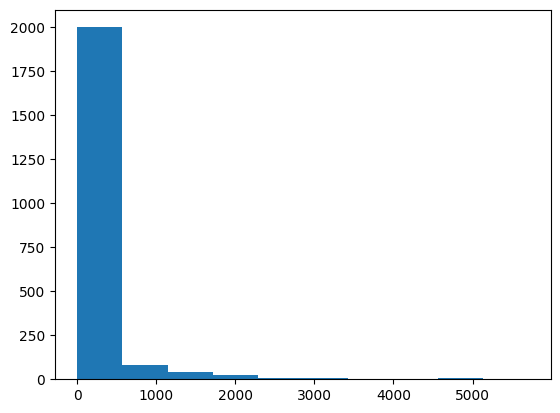

In [19]:
sequence_lengths = []

for i in range(len(X_train)):
  sequence_lengths.append(len(X_train[i]))

import matplotlib.pyplot as plt

plt.hist(sequence_lengths)

In [20]:
pd.Series(sequence_lengths).describe()

count    2174.000000
mean      182.814627
std       514.717545
min         1.000000
25%        16.000000
50%        31.500000
75%        60.000000
max      5706.000000
dtype: float64

In [21]:
from copy import deepcopy

def pad_X(X, desired_sequence_length=5710):
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_difference = desired_sequence_length - x_seq_len

    pad = np.zeros(shape=(sequence_length_difference, 50))

    X_copy[i] = np.concatenate([x, pad])

  return np.array(X_copy).astype(float)

In [22]:
X_train = pad_X(X_train)

X_train.shape

(2174, 5710, 50)

In [23]:
y_train.shape

(2174,)

In [24]:
X_val, y_val = df_to_X_y(val_df)
X_val = pad_X(X_val)

X_val.shape, y_val.shape

((402, 5710, 50), (402,))

In [25]:
X_test, y_test = df_to_X_y(test_df)
X_test = pad_X(X_test)

X_test.shape, y_test.shape

((403, 5710, 50), (403,))

# LSTM Model

In [26]:
model = Sequential([])

model.add(layers.Input(shape=(5710, 50)))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5710, 64)          29440     
                                                                 
 dropout (Dropout)           (None, 5710, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, 5710, 64)          33024     
                                                                 
 dropout_1 (Dropout)         (None, 5710, 64)          0         
                                                                 
 lstm_2 (LSTM)               (None, 5710, 64)          33024     
                                                                 
 dropout_2 (Dropout)         (None, 5710, 64)          0         
                                                                 
 flatten (Flatten)           (None, 365440)            0

In [28]:
fcp = ModelCheckpoint('model/', save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', AUC(name='auc')])

In [31]:
frequencies = pd.value_counts(train_df['Subjectivity'])

frequencies

Subjectivity
0.0    1087
1.0    1087
Name: count, dtype: int64

In [73]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [34]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp,early_stopping])

Epoch 1/20
68/68 [==============================] - 53s 665ms/step - loss: 1.3599 - accuracy: 0.5690 - auc: 0.5973 - val_loss: 0.6910 - val_accuracy: 0.6070 - val_auc: 0.6514
Epoch 2/20
68/68 [==============================] - 42s 622ms/step - loss: 1.3207 - accuracy: 0.6017 - auc: 0.6679 - val_loss: 0.6686 - val_accuracy: 0.6791 - val_auc: 0.7139
Epoch 3/20
68/68 [==============================] - 43s 633ms/step - loss: 1.2581 - accuracy: 0.6605 - auc: 0.7109 - val_loss: 0.6107 - val_accuracy: 0.6990 - val_auc: 0.7519
Epoch 4/20
68/68 [==============================] - 34s 501ms/step - loss: 1.2084 - accuracy: 0.6918 - auc: 0.7430 - val_loss: 0.6209 - val_accuracy: 0.6965 - val_auc: 0.7515
Epoch 5/20
68/68 [==============================] - 43s 628ms/step - loss: 1.1747 - accuracy: 0.7075 - auc: 0.7630 - val_loss: 0.5941 - val_accuracy: 0.7214 - val_auc: 0.7542
Epoch 6/20
68/68 [==============================] - 34s 501ms/step - loss: 1.1550 - accuracy: 0.6987 - auc: 0.7682 - val_loss

In [37]:
best_model = load_model('model/')

In [38]:
test_predictions = (best_model.predict(X_test) > 0.5).astype(int)

print(classification_report(y_test, test_predictions))

13/13 [==============================] - 5s 218ms/step
              precision    recall  f1-score   support

           0       0.61      0.54      0.58       166
           1       0.70      0.76      0.73       237

    accuracy                           0.67       403
   macro avg       0.66      0.65      0.65       403
weighted avg       0.67      0.67      0.67       403



## With wsd:

In [46]:
def new_df_to_X_y(dff):
  y = dff['Subjectivity'].to_numpy().astype(int)

  all_word_vector_sequences = []

  for message in dff['Comment']:
    message_as_vector_seq = word_sense_disambiguation(str(message))
    message_as_vector_seq = message_to_word_vectors(str(message_as_vector_seq))
    if message_as_vector_seq.shape[0] == 0:
      message_as_vector_seq = np.zeros(shape=(1, 50))

    all_word_vector_sequences.append(message_as_vector_seq)

  return all_word_vector_sequences, y

In [47]:
train_df = data.sample(frac=1, random_state=1)
train_df.reset_index(drop=True, inplace=True)

split_index_1 = int(len(train_df) * 0.7)
split_index_2 = int(len(train_df) * 0.85)

train_df, val_df, test_df = train_df[:split_index_1], train_df[split_index_1:split_index_2], train_df[split_index_2:]

len(train_df), len(val_df), len(test_df)

(1878, 402, 403)

balancing out train data:

In [48]:
X_train = train_df.drop(columns=['Subjectivity'])
y_train = train_df['Subjectivity']
oversampler = RandomOverSampler(random_state=42)
X_train_upsampled, y_train_upsampled = oversampler.fit_resample(X_train, y_train)
train_df = pd.concat([X_train_upsampled, y_train_upsampled], axis=1)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df['Subjectivity'].value_counts()

Subjectivity
0.0    1087
1.0    1087
Name: count, dtype: int64

In [49]:
X_train, y_train = new_df_to_X_y(train_df)
X_train = pad_X(X_train)
X_val, y_val = new_df_to_X_y(val_df)
X_val = pad_X(X_val)
X_test, y_test = new_df_to_X_y(test_df)
X_test = pad_X(X_test)

In [70]:
model1 = Sequential([])

model1.add(layers.Input(shape=(5710, 50)))
model1.add(layers.LSTM(64, return_sequences=True))
model1.add(layers.Dropout(0.2))
model1.add(layers.LSTM(64, return_sequences=True))
model1.add(layers.Dropout(0.2))
model1.add(layers.LSTM(64, return_sequences=True))
model1.add(layers.Dropout(0.2))
model1.add(layers.Flatten())
model1.add(layers.Dense(1, activation='sigmoid'))

In [71]:
cp = ModelCheckpoint('model1/', save_best_only=True)

model1.compile(optimizer=Adam(learning_rate=0.0001),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', AUC(name='auc')])

In [74]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [75]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp,early_stopping])

Epoch 1/20
68/68 [==============================] - 49s 658ms/step - loss: 0.6821 - accuracy: 0.5773 - auc: 0.6137 - val_loss: 0.6737 - val_accuracy: 0.6194 - val_auc: 0.7010
Epoch 2/20
68/68 [==============================] - 42s 620ms/step - loss: 0.6474 - accuracy: 0.6357 - auc: 0.6863 - val_loss: 0.6290 - val_accuracy: 0.7164 - val_auc: 0.7630
Epoch 3/20
68/68 [==============================] - 45s 662ms/step - loss: 0.6115 - accuracy: 0.6872 - auc: 0.7327 - val_loss: 0.6005 - val_accuracy: 0.7114 - val_auc: 0.7645
Epoch 4/20
68/68 [==============================] - 42s 621ms/step - loss: 0.5925 - accuracy: 0.6960 - auc: 0.7531 - val_loss: 0.5781 - val_accuracy: 0.7289 - val_auc: 0.7710
Epoch 5/20
68/68 [==============================] - 34s 498ms/step - loss: 0.5801 - accuracy: 0.7033 - auc: 0.7663 - val_loss: 0.5958 - val_accuracy: 0.7040 - val_auc: 0.7679
Epoch 6/20
68/68 [==============================] - 34s 498ms/step - loss: 0.5696 - accuracy: 0.7079 - auc: 0.7745 - val_loss

In [77]:
best_model1 = load_model('model1/')

In [78]:
test_predictions = (best_model1.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, test_predictions))

13/13 [==============================] - 4s 223ms/step
              precision    recall  f1-score   support

           0       0.65      0.48      0.55       166
           1       0.69      0.82      0.75       237

    accuracy                           0.68       403
   macro avg       0.67      0.65      0.65       403
weighted avg       0.67      0.68      0.67       403



# Keras Tuner (without wsd)

In [50]:
def model_builder(hp):
  model1 = Sequential([])

  model1.add(layers.Input(shape=(5710, 50)))
  model1.add(layers.LSTM(hp.Int('layer_1', min_value=16, max_value=256, step=32), return_sequences=True))
  model1.add(layers.Dropout(hp.Float('dropout_rate_1', min_value=0.0, max_value=0.5, step=0.1)))
  model1.add(layers.LSTM(hp.Int('layer_2', min_value=16, max_value=256, step=32), return_sequences=True))
  model1.add(layers.Dropout(hp.Float('dropout_rate_2', min_value=0.0, max_value=0.5, step=0.1)))
  model1.add(layers.LSTM(hp.Int('layer_3', min_value=16, max_value=256, step=32), return_sequences=True))
  model1.add(layers.Dropout(hp.Float('dropout_rate_3', min_value=0.0, max_value=0.5, step=0.1)))
  model1.add(layers.Flatten())
  model1.add(layers.Dense(1, activation='sigmoid'))

  model1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                loss=BinaryCrossentropy(),
                metrics=['accuracy', AUC(name='auc')])

  return model1

In [53]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='dir',
                     project_name='x',
                     )

In [54]:
# import shutil
# shutil.rmtree('/content/new_dir')

In [55]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [56]:
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

Trial 30 Complete [00h 05m 59s]
val_accuracy: 0.7338308691978455

Best val_accuracy So Far: 0.7338308691978455
Total elapsed time: 01h 24m 46s


In [57]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [58]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                    callbacks=[stop_early])

Epoch 1/50
68/68 [==============================] - 41s 539ms/step - loss: 0.6905 - accuracy: 0.5603 - auc: 0.5785 - val_loss: 0.6917 - val_accuracy: 0.5398 - val_auc: 0.5841
Epoch 2/50
68/68 [==============================] - 34s 504ms/step - loss: 0.6845 - accuracy: 0.5787 - auc: 0.5960 - val_loss: 0.6860 - val_accuracy: 0.6318 - val_auc: 0.5826
Epoch 3/50
68/68 [==============================] - 34s 504ms/step - loss: 0.6783 - accuracy: 0.5837 - auc: 0.6051 - val_loss: 0.6863 - val_accuracy: 0.6244 - val_auc: 0.5779
Epoch 4/50
68/68 [==============================] - 34s 506ms/step - loss: 0.6735 - accuracy: 0.6003 - auc: 0.6153 - val_loss: 0.6746 - val_accuracy: 0.6194 - val_auc: 0.5923
Epoch 5/50
68/68 [==============================] - 34s 503ms/step - loss: 0.6687 - accuracy: 0.5943 - auc: 0.6173 - val_loss: 0.6810 - val_accuracy: 0.6244 - val_auc: 0.5963
Epoch 6/50
68/68 [==============================] - 34s 507ms/step - loss: 0.6651 - accuracy: 0.5911 - auc: 0.6342 - val_loss

In [59]:
history.history

{'loss': [0.6904698610305786,
  0.684536874294281,
  0.6783027648925781,
  0.6734702587127686,
  0.6687051057815552,
  0.6650797128677368,
  0.660874605178833,
  0.6573325395584106,
  0.6500028371810913,
  0.6457573175430298,
  0.6402540802955627,
  0.631996214389801,
  0.623492956161499,
  0.6189131140708923,
  0.6091862916946411,
  0.6053826808929443,
  0.6020963191986084,
  0.5988948345184326,
  0.5953424572944641,
  0.5924694538116455,
  0.5902703404426575],
 'accuracy': [0.560257613658905,
  0.5786568522453308,
  0.583716630935669,
  0.600275993347168,
  0.5942962169647217,
  0.5910763740539551,
  0.6062557697296143,
  0.6071757078170776,
  0.6200551986694336,
  0.6292548179626465,
  0.6435142755508423,
  0.650413990020752,
  0.6637534499168396,
  0.6614535450935364,
  0.6743330359458923,
  0.6775528788566589,
  0.6844525933265686,
  0.6784728765487671,
  0.6918123364448547,
  0.6968721151351929,
  0.7010119557380676],
 'auc': [0.5784639120101929,
  0.5960112810134888,
  0.6050971

In [68]:
test_predictions = (best_model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, test_predictions))

13/13 [==============================] - 3s 239ms/step
              precision    recall  f1-score   support

           0       0.58      0.63      0.61       166
           1       0.73      0.68      0.70       237

    accuracy                           0.66       403
   macro avg       0.65      0.66      0.65       403
weighted avg       0.67      0.66      0.66       403



In [69]:
best_model.save('LSTM_best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
